In [ ]:
%matplotlib inline 

import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn

from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import r2_score

from tensorflow.keras.models import Sequential # layer-by-layer construction
from tensorflow.keras.layers import Dense, Flatten, Dropout, Layer, Input, Lambda
from tensorflow.nn import relu, tanh # activation functions

from keras.layers import Dropout
from keras.layers import GaussianNoise

In [ ]:
# print package versions
print("numpy version:", np.__version__)
print("tensorflow version:", tf.__version__)
print("pandas version:", pd.__version__)
print("sklearn version:", sklearn.__version__)

numpy version: 1.21.6
tensorflow version: 2.8.2
pandas version: 1.3.5
sklearn version: 1.0.2


In [ ]:
# set random seed for reproducible results
SEED = 42004
np.random.seed(SEED)
tf.random.set_seed(SEED)

tf.compat.v1.set_random_seed(SEED)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import FCNN training and validation dataset

In [ ]:
# import dataset
data = pd.read_excel('/content/drive/My Drive/CEE696/Rn_DL_rawdata2.xlsx')

# define column names; water depth (owl; m), water temp (ctdtemp; deg C), 
# and salinity (ctdsal) are parameters measured at the location of the radon 
# time series using a CTD diver or similar sensor. Wind speed (m/s), and
# air temperature (deg C) can be obtained from a local meteorological station, 
# Rn-222 in water (Bq/m^3) is obtained using a radon-in-air detector or similar.
data.columns = ['datetime', 'Location', 'Aquifer_type', 'owl_m', 'ctdtemp_C',
                 'ctdsal', 'windsp_ms', 'airtemp_C', 'Rn_Bqm3'] 

# convert first column to datetime format
data.Datetime = pd.to_datetime(data.datetime)

# drop variables that will not be used in model
data = data.drop(['datetime', 'Aquifer_type'], axis = 1)

# drop rows with missing values
data = data.dropna()
data.head()

,Location,owl_m,ctdtemp_C,ctdsal,windsp_ms,airtemp_C,Rn_Bqm3
0,Wailupe,1.0,29.55,31.29,5.277778,28.0,0.0
1,Wailupe,1.0,29.50,31.23,6.111111,28.5,0.0
2,Wailupe,1.0,30.45,32.00,7.222222,28.4,0.0
3,Wailupe,1.0,30.46,31.49,6.111111,28.2,0.0
4,Wailupe,1.0,30.76,32.59,8.333333,28.3,0.0


## Pre-processing

In [ ]:
# print min and max values; if var has negative min vlaue, then need to rescale
print(np.min(data))
print(np.max(data))

Location     Akziv, Israel
owl_m                -1.71
ctdtemp_C             9.04
ctdsal            0.123587
windsp_ms              0.0
airtemp_C            -6.75
Rn_Bqm3                0.0
dtype: object
Location         Wailupe
owl_m              16.72
ctdtemp_C      40.599614
ctdsal         49.304814
windsp_ms          19.72
airtemp_C           42.0
Rn_Bqm3      7867.406779
dtype: object


In [ ]:
# rescale minimum to 0 for variables with negative values
data['owl_m'] = data['owl_m'] + abs(np.min(data['owl_m']))
data['airtemp_C'] =  data['airtemp_C'] + abs(np.min(data['airtemp_C']))
data['windsp_ms'] =  data['windsp_ms'] + abs(np.min(data['windsp_ms']))

print(np.min(data))

Location     Akziv, Israel
owl_m                  0.0
ctdtemp_C             9.04
ctdsal            0.123587
windsp_ms              0.0
airtemp_C              0.0
Rn_Bqm3                0.0
dtype: object


In [ ]:
# normalize data
data_norm = data

data_norm['owl_m'] = (data['owl_m'] - min(data['owl_m'])) / (max(data['owl_m']) - min(data['owl_m']))
data_norm['ctdtemp_C'] = (data['ctdtemp_C'] - min(data['ctdtemp_C'])) / (max(data['ctdtemp_C']) - min(data['ctdtemp_C']))
data_norm['ctdsal'] = (data['ctdsal'] - min(data['ctdsal'])) / (max(data['ctdsal']) - min(data['ctdsal']))
data_norm['airtemp_C'] = (data['airtemp_C'] - min(data['airtemp_C'])) / (max(data['airtemp_C']) - min(data['airtemp_C']))
data_norm['windsp_ms'] = (data['windsp_ms'] - min(data['windsp_ms'])) / (max(data['windsp_ms']) - min(data['windsp_ms']))
data_norm['Rn_Bqm3'] = (data['Rn_Bqm3'] - min(data['Rn_Bqm3'])) / (max(data['Rn_Bqm3']) - min(data['Rn_Bqm3']))

print(np.min(data_norm))
print(np.max(data_norm))

Location     Akziv, Israel
owl_m                  0.0
ctdtemp_C              0.0
ctdsal                 0.0
windsp_ms              0.0
airtemp_C              0.0
Rn_Bqm3                0.0
dtype: object
Location     Wailupe
owl_m            1.0
ctdtemp_C        1.0
ctdsal           1.0
windsp_ms        1.0
airtemp_C        1.0
Rn_Bqm3          1.0
dtype: object


In [ ]:
# split data into training and validation sets using sklearn with data from each
# field site
from sklearn.model_selection import train_test_split

train, test = train_test_split(data_norm, test_size = 0.2, 
                               stratify = data_norm["Location"])

# confirm NaNs removed from both sets
train = train.dropna()
test = test.dropna()

In [ ]:
# export training and validation sets to xlsx for future reference
train.to_excel('FCNN_train1.xlsx')
!cp FCNN_train1.xlsx "/content/drive/My Drive/CEE696/"

test.to_excel('FCNN_test1.xlsx')
!cp FCNN_test1.xlsx "/content/drive/My Drive/CEE696/"

In [ ]:
# check proportions by location of test and validation sets
def get_class_counts(df):
  grp = df.groupby(['Location'])['Rn_Bqm3'].nunique()
  return {key:grp[key] for key in list(grp.keys())}

def get_class_proportions(df):
  class_counts = get_class_counts(df)
  return {val[0]: round(val[1]/df.shape[0], 4) for val in class_counts.items()}

train_class_proportions = get_class_proportions(train)
test_class_proportions = get_class_proportions(test)

print("train proportions:", train_class_proportions)
print("test proportions:", test_class_proportions)

train proportions: {'Akziv, Israel': 0.0009, 'American Samoa': 0.0005, 'Bali 2018 ts': 0.0037, 'Barwon, Aus 2014 ts': 0.0034, 'BlackPoint': 0.0166, 'Cook Island - 2012 ts': 0.0023, 'Darwin 2014 ts': 0.003, 'Dauphin': 0.0486, 'Dor Beach, Israel': 0.0097, 'Florida': 0.2274, 'Gakko River, Japan': 0.0012, 'Hat Head 3 wet, Aus 2013 ts': 0.001, 'Hat Head dry 3, Aus 2013 ts': 0.0017, 'Hat Head dry2, Aus 2013 ts': 0.0017, 'Hat Head wet 1 2013 ts': 0.0012, 'Hat Head wet2, Aus 2013 ts': 0.0011, 'HatHead wet 4, Aus 2013 ts': 0.001, 'Heron Island - 2011 ts': 0.0051, 'Hinch, Aus 2014 ts': 0.003, 'Honokohau, HI, USA': 0.0011, 'Hood Canal, WA, USA': 0.0031, 'Jacobs Well, Aus 2013 ts': 0.0089, 'Kaimaiso, Japan': 0.001, 'KasitsnaBay1': 0.0037, 'KasitsnaBay2': 0.0019, 'Kiholo': 0.3261, 'Little Lagoon, AL, USA': 0.0006, 'Manila Bay, Philippines': 0.0011, 'Marina Lagoon, Egypt': 0.003, 'One Tree Island - 2017 ts': 0.0078, 'Sydney, Aus 2015 ts': 0.0021, 'Toms Creek, Aus 2014 ts': 0.0028, 'Wailupe': 0.0125}

In [ ]:
# split x, y into training and validation sets
train = train.drop(['Location'], axis = 1)
test = test.drop(['Location'], axis = 1)

X_train = train.drop(['Rn_Bqm3'], axis = 1)
y_train = train['Rn_Bqm3']

X_test = test.drop(['Rn_Bqm3'], axis = 1)
y_test = test['Rn_Bqm3']

# make sure dtypes for x, y are floats
X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')

X_test = np.asarray(X_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')

# FCNN Model

In [ ]:
# define model
model = Sequential()

#a = -0.7

init = tf.keras.initializers.HeUniform()

model.add(Dense(units = 128, activation = 'relu', kernel_initializer = init, 
                kernel_regularizer = tf.keras.regularizers.L1L2(0.0001)))
model.add(Dense(units = 64, kernel_initializer = init)) 
model.add(Dense(units = 20))
model.add(Dense(units = 6, activation = 'selu'))

model.add(Dense(units = 450, activation = 'relu'))
model.add(Dense(units = 230, activation = 'relu'))
model.add(Dropout(0.32))

model.add(Dense(units = 105, activation = 'relu'))
model.add(Dense(units = 26, activation = 'relu'))
model.add(Dense(units = 10, activation = 'relu'))

model.add(Dense(units = 26))
model.add(Dropout(0.05))
model.add(Dense(1, activation = 'tanh'))

# reduce learning rate on plateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', 
                                                 factor = 0.8,
                                                 patience = 12,
                                                 min_lr = 1E-5)

# early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 15)

# compile FCNN with learning rate optimizer & early stopping; monitor MAE, RMSE
model.compile(optimizer= tf.keras.optimizers.Adam(epsilon = 1e-07,
                                                  amsgrad = False), 
                                                  loss='mae', 
              metrics = ['mean_absolute_error', 'RootMeanSquaredError'])

In [ ]:
# Fit the model
hist = model.fit(X_train, y_train, 
                 validation_data = (X_test, y_test), 
                 epochs = 500, batch_size = 225,
                 callbacks = [callback, reduce_lr], verbose = 1) 

Epoch 1/500
140/140 [==============================] - 3s 12ms/step - loss: 0.0540 - mean_absolute_error: 0.0199 - root_mean_squared_error: 0.0407 - val_loss: 0.0493 - val_mean_absolute_error: 0.0176 - val_root_mean_squared_error: 0.0385 - lr: 0.0010
Epoch 2/500
140/140 [==============================] - 1s 11ms/step - loss: 0.0470 - mean_absolute_error: 0.0175 - root_mean_squared_error: 0.0384 - val_loss: 0.0435 - val_mean_absolute_error: 0.0163 - val_root_mean_squared_error: 0.0363 - lr: 0.0010
Epoch 3/500
140/140 [==============================] - 1s 11ms/step - loss: 0.0425 - mean_absolute_error: 0.0173 - root_mean_squared_error: 0.0384 - val_loss: 0.0404 - val_mean_absolute_error: 0.0171 - val_root_mean_squared_error: 0.0378 - lr: 0.0010
Epoch 4/500
140/140 [==============================] - 2s 11ms/step - loss: 0.0387 - mean_absolute_error: 0.0171 - root_mean_squared_error: 0.0382 - val_loss: 0.0362 - val_mean_absolute_error: 0.0162 - val_root_mean_squared_error: 0.0367 - lr: 0.0

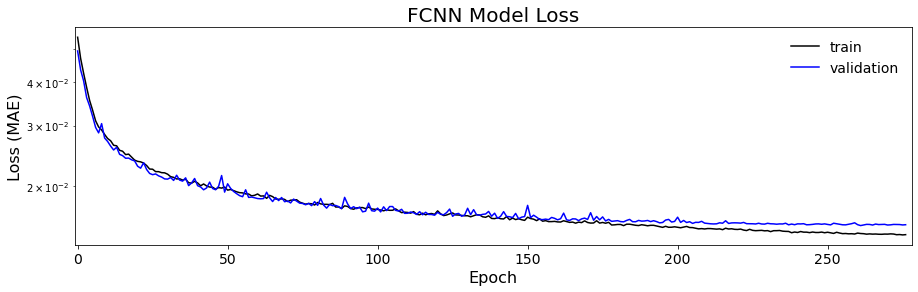

In [ ]:
# plot model convergence
plt.figure(figsize = (15,4))
plt.tick_params(labelsize = 14)
plt.semilogy(hist.history['loss'], color = 'black')
plt.semilogy(hist.history['val_loss'], color = 'blue')
plt.tick_params(labelsize = 14)
plt.title('FCNN Model Loss', fontsize = 20)
plt.ylabel('Loss (MAE)', fontsize = 16)
plt.xlabel('Epoch', fontsize = 16)
plt.legend(['train', 'validation'], loc='upper right', frameon = False, 
           fontsize = 14)

plt.xlim(-1, 278)

plt.show()

## Model prediction (training & validation set)

In [ ]:
# Rn prediction
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# concat training and validation
y_pred = np.concatenate((y_train_pred, y_test_pred), axis = 0)

# evaluate model
test_loss_a = model.evaluate(X_train, y_train)
test_loss_b = model.evaluate(X_test, y_test)

print(test_loss_a)
print(test_loss_b)

246/246 [==============================] - 0s 2ms/step - loss: 0.0155 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0266
[0.014114337973296642, 0.01235426589846611, 0.02367260307073593]
[0.015486858785152435, 0.013726774603128433, 0.026613853871822357]


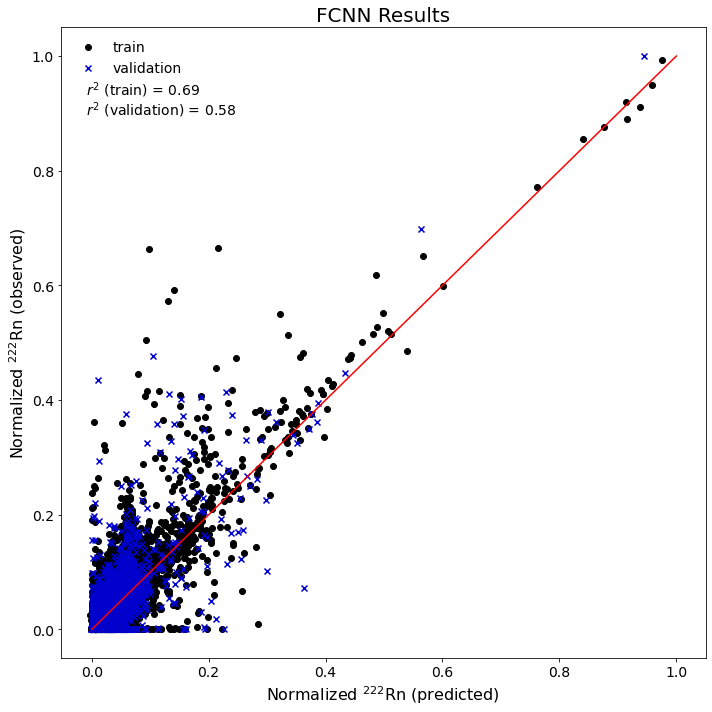

In [ ]:
# calculate r^2 between predicted and observed Rn
R2_train = r2_score(y_train, y_train_pred, multioutput = 'variance_weighted')
R2_test = r2_score(y_test, y_test_pred, multioutput = 'variance_weighted')

# plot y vs y pred 45 degree mismatch (with train/validation split)
plt.figure(figsize = (10,10))
plt.scatter(y_train_pred, y_train, alpha = 1, label = 'train', color = 'black')
plt.scatter(y_test_pred, y_test, alpha = 1, label = 'validation', marker ='x', 
            color = 'mediumblue')

plt.legend(frameon = False, fontsize = 14)
plt.xlabel('Normalized $^{222}$Rn (predicted)', fontsize = 16)
plt.ylabel('Normalized $^{222}$Rn (observed)', fontsize = 16)
plt.title('FCNN Results', fontsize = 20)
 
# plot 45 degree line
x1 = np.linspace(0, 1, 1000)
plt.plot(x1,x1, c = "red") 

# plot r^2 results on figure
plt.text(-0.01, 0.933, '$r^2$ (train) = %0.2f' % R2_train, fontsize = 14)
plt.text(-0.01, 0.898, '$r^2$ (validation) = %0.2f' % R2_test, fontsize = 14)

plt.tick_params(labelsize = 14)
plt.tight_layout()

plt.show()

# Prediction of new data using trained model

## Pre-processing

In [ ]:
# import new data for use with pre-trained model

# import dataset, replace "filename.xlsx" with the name of the file
data_A = pd.read_excel('filename.xlsx')

# define column names; water depth (owl; m), water temp (ctdtemp; deg C), 
# and salinity (ctdsal) are parameters measured at the location of the radon 
# time series using a CTD diver or similar sensor. Wind speed (m/s), and
# air temperature (deg C) can be obtained from a local meteorological station, 
# Rn-222 in water (Bq/m^3) is obtained using a radon-in-air detector or similar.
data_A.columns = ['datetime', 'Location', 'Aquifer_type', 'owl_m', 'ctdtemp_C',
                 'ctdsal', 'windsp_ms', 'airtemp_C', 'Rn_Bqm3'] 

# convert first column to datetime format
data_A.Datetime = pd.to_datetime(data_A.datetime)

# drop variables that will not be used in model
data_A = data_A.drop(['datetime', 'Aquifer_type'], axis = 1)

# drop rows with missing values
data_A = data_A.dropna()
data_A.head()

In [ ]:
# print min and max values; if var has negative min vlaue, then need to rescale
# note: min and max values must be within the range in the model was trained
# with
print(np.min(data_A))
print(np.max(data_A))

In [ ]:
# rescale minimum to 0 for variables with negative values
data_A['owl_m'] = data_A['owl_m'] + abs(np.min(data_A['owl_m']))
data_A['airtemp_C'] =  data_A['airtemp_C'] + abs(np.min(data_A['airtemp_C']))
data_A['windsp_ms'] =  data_A['windsp_ms'] + abs(np.min(data_A['windsp_ms']))

print(np.min(data_A))

In [ ]:
# normalize data
data_A_norm = data_A

data_A_norm['owl_m'] = (data_A['owl_m'] - min(data_A['owl_m'])) / (max(data_A['owl_m']) - min(data_A['owl_m']))
data_A_norm['ctdtemp_C'] = (data_A['ctdtemp_C'] - min(data_A['ctdtemp_C'])) / (max(data_A['ctdtemp_C']) - min(data_A['ctdtemp_C']))
data_A_norm['ctdsal'] = (data_A['ctdsal'] - min(data_A['ctdsal'])) / (max(data_A['ctdsal']) - min(data_A['ctdsal']))
data_A_norm['airtemp_C'] = (data_A['airtemp_C'] - min(data_A['airtemp_C'])) / (max(data_A['airtemp_C']) - min(data_A['airtemp_C']))
data_A_norm['windsp_ms'] = (data_A['windsp_ms'] - min(data_A['windsp_ms'])) / (max(data_A['windsp_ms']) - min(data_A['windsp_ms']))
data_A_norm['Rn_Bqm3'] = (data_A['Rn_Bqm3'] - min(data_A['Rn_Bqm3'])) / (max(data_A['Rn_Bqm3']) - min(data_A['Rn_Bqm3']))

print(np.min(data_A_norm))
print(np.max(data_A_norm))

In [ ]:
# split X (input variables) and y (predictive variable)
X_A = data_A_norm.drop(['Rn_Bqm3'], axis = 1)
y_A = data_A_norm['Rn_Bqm3']

## Model prediction

In [ ]:
# evaluate newly imported dataset using pretrained model
y_test_A = model.predict(X_A)
test_loss_A = model.evaluate(X_A, y_A)
print(test_loss_A)

In [ ]:
# y vs y pred 45 degree mismatch for new data
plt.figure(figsize = (10,10))

plt.scatter(y_test_A, y_A, alpha = 1, label = 'new data', color = 'yellowgreen')
plt.scatter(y_train_pred, y_train, alpha = 1, label = 'train', color = 'black')
plt.scatter(y_test_pred, y_test, alpha = 1, label = 'validation', marker ='x', 
            color = 'mediumblue')

plt.legend(frameon = False, fontsize = 14)
plt.xlabel('Normalized $^{222}$Rn (predicted)', fontsize = 16)
plt.ylabel('Normalized $^{222}$Rn (observed)', fontsize = 16)
plt.title('FCNN Results', fontsize = 20)
 
# plot 45 degree line
x1 = np.linspace(0, 1, 1000)
plt.plot(x1,x1, c = "red") 

# r^2
R2_A = r2_score(y_A, y_test_A, multioutput='variance_weighted')
print(R2_A)
plt.text(0.001, 0.98, '$r^2$ = %0.2f' % R2_A, fontsize = 14)

plt.tick_params(labelsize = 14)
plt.tight_layout()

plt.show()